# Basic Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import graphviz

In [2]:
# This cell is for fetcching dataset from UC Irvine
# 16 features
# 2111 raw data points
# UC Irvine - "77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform."
# Related Data Article is accessible here >> https://doi.org/10.1016/j.dib.2019.104344

from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 

# data (as pandas dataframes) 
raw_X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
raw_y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets 

# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 

# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 

# raw_X.describe()

# Creating a combined df for analysis
raw_combined_df = pd.concat([raw_X, raw_y], axis=1)


{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

# Data Preprocessing

In [3]:
# No null values are found accross the dataset, so we can move forward with the raw dataset
print(raw_X.isnull().sum())
# The main page of the dataset also lists that no missing values in any attributes are found in any data points

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


In [4]:
raw_X.dtypes
# raw_y.dtypes


Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

### Data Preprocessing - Converting attributes to numerical values
&nbsp;&nbsp;&nbsp;&nbsp;Our Conversion Scalling is built to ensure any object values in the original "raw" dataframes is converted to float64 values in "clean" dataframes. Various attributes are originally stored as objects, shown as either 'yes' or 'no'. In these scenarios, they're converted to float64 as 1.0 or 2.0 respectively.

&nbsp;&nbsp;&nbsp;&nbsp;In cases where the attribute may have various different classes, our conversion scalling sets less healthy characteristics as lower counts and more healthy characteristics as higher counts. This is done in order to require the least complexity from the decision tree. For example, the CAEC attribute can have the classes 'Sometimes', 'Frequently', 'Always' or 'no'. When converted to numerics however, the order is specified, sometimes changed, respective to their value. 'no' is set to the lowest (0), 'Sometimes' is set to 1, 'Frequently' is set to 2 and 'Always' is set to 3.

&nbsp;&nbsp;&nbsp;&nbsp;These form of ordering isn't precise however, as it's either based on correlation or intuition. For example, walking to work would presumably mean the patient is healthier than someone who normally drives to work. However, as are most correlations found data sience, these presumptions could actually be fallacies, resulting in a more complex decision tree to get definitive results.

&nbsp;&nbsp;&nbsp;&nbsp;This became particularly difficult when converting MTRANS (an attribute recording the main form of transportation used by each person). To make a good ordering system, we ran analysis on the correlations between MTRANS and NObeyesdad (the target attribute). Both the correlation matrix and written analysis can be found below.

&nbsp;&nbsp;&nbsp;&nbsp;As for the Target Attribute (NObeyesdad), the classes are each classifications of their own of BMI values (Body Mass Index). The scalling is just done from lowest BMI to highest. Insufficient_Weight essentially means underweight.


In [5]:
print(raw_X["Gender"].unique())

['Female' 'Male']


In [6]:
print(raw_X["family_history_with_overweight"].unique())

['yes' 'no']


In [7]:
print(raw_X["FAVC"].unique())

['no' 'yes']


In [8]:
print(raw_X["CAEC"].unique())

['Sometimes' 'Frequently' 'Always' 'no']


In [9]:
print(raw_X["SMOKE"].unique())

['no' 'yes']


In [10]:
print(raw_X["SCC"].unique())

['no' 'yes']


In [11]:
print(raw_X["CALC"].unique())

['no' 'Sometimes' 'Frequently' 'Always']


In [12]:
print(raw_X["MTRANS"].unique())

['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [13]:
# raw_y.describe()
print(raw_y["NObeyesdad"].value_counts())

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


In [14]:
correlation_table = pd.crosstab(raw_X["MTRANS"], raw_y["NObeyesdad"])
print(correlation_table)

NObeyesdad             Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
MTRANS                                                                      
Automobile                              46             45             110   
Bike                                     0              4               0   
Motorbike                                0              6               3   
Public_Transportation                  220            200             236   
Walking                                  6             32               2   

NObeyesdad             Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
MTRANS                                                                         
Automobile                          95                 1                  66   
Bike                                 1                 0                   2   
Motorbike                            0                 0                   1   
Public_Transportation              200               323    

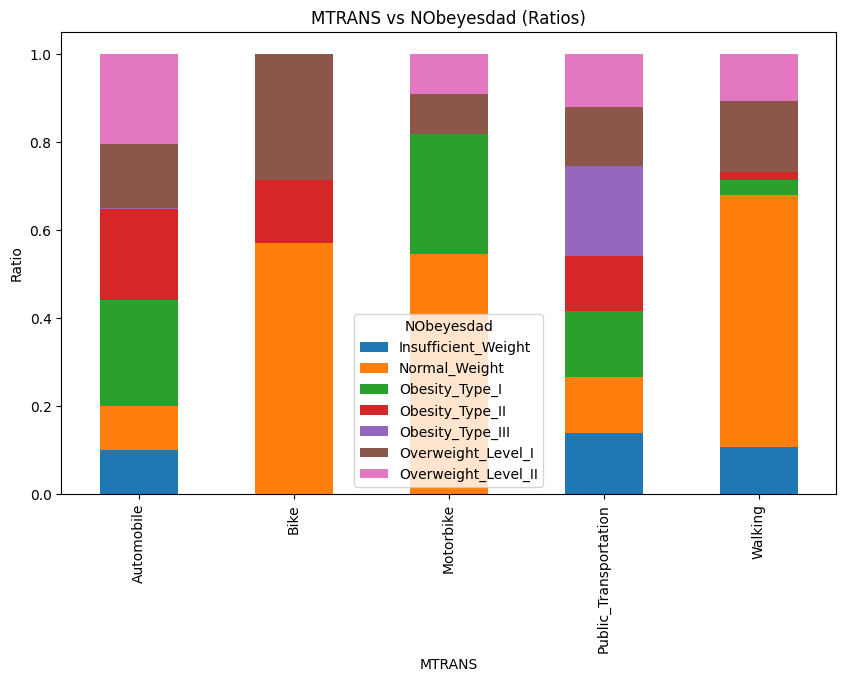

In [15]:
correlation_ratio = pd.crosstab(raw_X["MTRANS"], raw_y["NObeyesdad"], normalize='index')
correlation_ratio.plot(kind="bar", stacked=True, figsize=(10,6))
plt.ylabel("Ratio")
plt.title("MTRANS vs NObeyesdad (Ratios)")
plt.show()

### Data Preprocessing - Correlation Evaluation to determine how to convert MTRANS attribute values to numerical values

&nbsp;&nbsp;&nbsp;&nbsp;Automobile is essentially the control group, so it's set to 0, while all other MTRANS classes are set to values above/below Automobile accordingly. Public_Transportation would presumably be better than Automobile since one would have to walk to/from stations, but data shows this to host the highest abesity level. As a result, it's set to -1. Motorcycle is set better than automobile, at 1. Even though it doesn't directly involve physical activity, they intuitively require some level of athleticism. Bike is set as the next best classification as 2 as it displays comparitively more data points of normal weight and it intuitively requires more athleticism. For the same reasons, Walking is set as a value as 3.

In [16]:
clean_X = raw_X.copy()

# Converting Gender
clean_X["Gender"] = clean_X["Gender"].replace({"Female": 1, "Male": 2})
clean_X["Gender"] = clean_X["Gender"].infer_objects(copy=False).astype("float64")

# Converting 'family_history_with_overweight'
clean_X["family_history_with_overweight"] = clean_X["family_history_with_overweight"].replace({"yes": 1, "no": 2})
clean_X["family_history_with_overweight"] = clean_X["family_history_with_overweight"].infer_objects(copy=False).astype("float64")

# Converting FAVC
# FAVC - Do you eat high caloric food frequently?
clean_X["FAVC"] = clean_X["FAVC"].replace({"yes": 1, "no": 2})
clean_X["FAVC"] = clean_X["FAVC"].infer_objects(copy=False).astype("float64")

# Converting CAEC
# CAEC - Do you eat any food between meals?
clean_X["CAEC"] = clean_X["CAEC"].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
clean_X["CAEC"] = clean_X["CAEC"].infer_objects(copy=False).astype("float64")

# Converting SMOKE
# SMOKE - Do you smoke?
clean_X["SMOKE"] = clean_X["SMOKE"].replace({"yes": 1, "no": 2})
clean_X["SMOKE"] = clean_X["SMOKE"].infer_objects(copy=False).astype("float64")

# Converting SCC
# SCC - Do you monitor the calories you eat daily?
clean_X["SCC"] = clean_X["SCC"].replace({"yes": 1, "no": 2})
clean_X["SCC"] = clean_X["SCC"].infer_objects(copy=False).astype("float64")

# Converting CALC
# CALC - How often do you drink alcohol
clean_X["CALC"] = clean_X["CALC"].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
clean_X["CALC"] = clean_X["CALC"].infer_objects(copy=False).astype("float64")

# Converting MTRANS
# MTRANS - Which transportation do you usually use?
clean_X["MTRANS"] = clean_X["MTRANS"].replace({"Public_Transportation": -1, "Automobile": 0, "Motorbike": 1, "Bike": 2, "Walking": 3})
clean_X["MTRANS"] = clean_X["MTRANS"].infer_objects(copy=False).astype("float64")


# Converting NObeyesdad
# NObeyesdad - Target Attribute - Level of Obesity
clean_y = raw_y.copy()

clean_y["NObeyesdad"] = clean_y["NObeyesdad"].replace({"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6})
clean_y["NObeyesdad"] = clean_y["NObeyesdad"].infer_objects(copy=False).astype("float64")


C:\Users\Thejas\AppData\Local\Temp\ipykernel_18040\1212532496.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_X["Gender"] = clean_X["Gender"].replace({"Female": 1, "Male": 2})
C:\Users\Thejas\AppData\Local\Temp\ipykernel_18040\1212532496.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_X["family_history_with_overweight"] = clean_X["family_history_with_overweight"].replace({"yes": 1, "no": 2})
C:\Users\Thejas\AppData\Local\Temp\ipykernel_18040\1212532496.py:13: FutureWarning: Downcasting behavior in `replace` is 

In [17]:
clean_X.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,1.505921,24.312600,1.701677,86.586058,1.182378,1.116059,2.419043,2.685628,1.140692,1.979157,2.008011,1.954524,1.010298,0.657866,0.731407,-0.657035
std,0.500083,6.345968,0.093305,26.191172,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,0.757801
min,1.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,19.947192,1.630000,65.473343,1.000000,1.000000,2.000000,2.658738,1.000000,2.000000,1.584812,2.000000,0.124505,0.000000,0.000000,-1.000000
50%,2.000000,22.777890,1.700499,83.000000,1.000000,1.000000,2.385502,3.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.625350,1.000000,-1.000000
75%,2.000000,26.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,2.477420,2.000000,1.666678,1.000000,1.000000,0.000000
max,2.000000,61.000000,1.980000,173.000000,2.000000,2.000000,3.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000


### Data Preprocessing - Standardization and Normalization
To recap, the evolution of the dataset is as follows:

raw_X - Raw Dataset

clean_X - raw_X with conversions from object to float64, requiring ordering in some cases

scaled_X - clean_X with standardization and normalization

In [18]:
# standardize and normalize the features
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

scaled_y = clean_y

scaled_X = std_scaler.fit_transform(clean_X)

scaled_X = pd.DataFrame(scaled_X, columns=clean_X.columns)
scaled_X.head()

# Creating a combined df for analysis
scaled_X_scaled = pd.concat([scaled_X, scaled_y], axis=1)

In [19]:
scaled_X.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
count,2.111000e+03,2111.000000,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03
mean,2.086862e-16,0.000000,-5.385449e-16,-5.385449e-16,-2.423452e-16,-1.346362e-16,-1.346362e-17,4.964711e-16,-1.884907e-16,-4.039087e-17,1.077090e-16,1.615635e-16,2.692725e-17,-1.346362e-17,5.048859e-17,4.039087e-17
std,1.000237e+00,1.000237,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00
min,-1.011914e+00,-1.625448,-2.698006e+00,-1.817304e+00,-4.722913e-01,-3.623491e-01,-2.658379e+00,-2.167023e+00,-2.435125e+00,-6.853997e+00,-1.644905e+00,-4.581439e+00,-1.188039e+00,-1.080625e+00,-1.419172e+00,-4.526871e-01
25%,-1.011914e+00,-0.688066,-7.683883e-01,-8.062914e-01,-4.722913e-01,-3.623491e-01,-7.850187e-01,-3.456952e-02,-3.003456e-01,1.459003e-01,-6.905894e-01,2.182720e-01,-1.041630e+00,-1.080625e+00,-1.419172e+00,-4.526871e-01
50%,9.882266e-01,-0.241897,-1.263207e-02,-1.369510e-01,-4.722913e-01,-3.623491e-01,-6.283450e-02,4.041527e-01,-3.003456e-01,1.459003e-01,-1.307326e-02,2.182720e-01,-1.210937e-02,-5.341135e-02,5.211595e-01,-4.526871e-01
75%,9.882266e-01,0.265964,7.159595e-01,7.960531e-01,-4.722913e-01,-3.623491e-01,1.088342e+00,4.041527e-01,-3.003456e-01,1.459003e-01,7.659959e-01,2.182720e-01,7.718565e-01,5.619968e-01,5.211595e-01,8.672335e-01
max,9.882266e-01,5.782584,2.983646e+00,3.300136e+00,2.117337e+00,2.759769e+00,1.088342e+00,1.689740e+00,3.969213e+00,1.459003e-01,1.618759e+00,2.182720e-01,2.339750e+00,2.204618e+00,4.401822e+00,4.826995e+00


## Data Preprocessing - Dataset Analysis

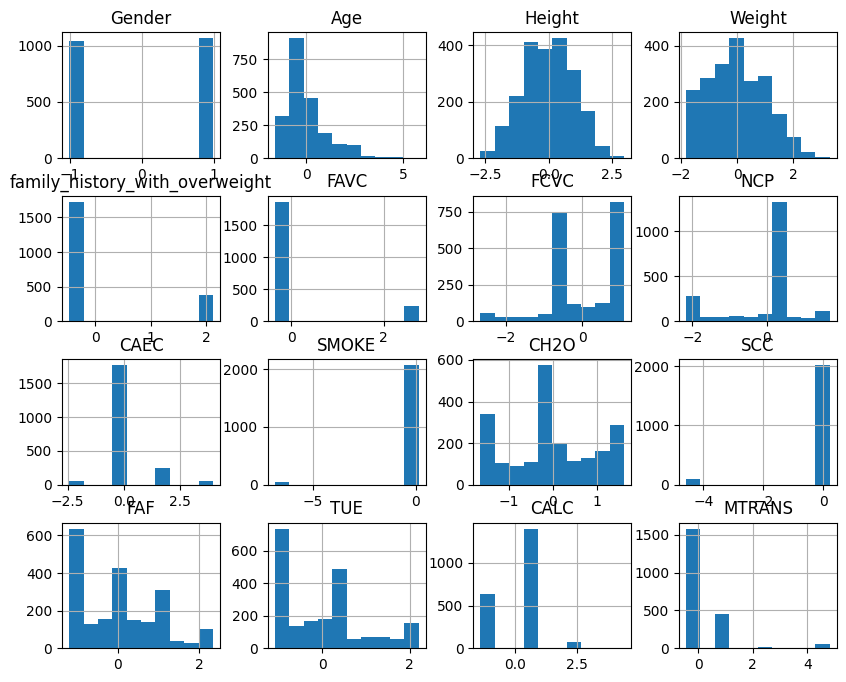

In [20]:
scaled_X.hist(figsize=(10, 8), bins=10)
plt.show()

<Axes: >

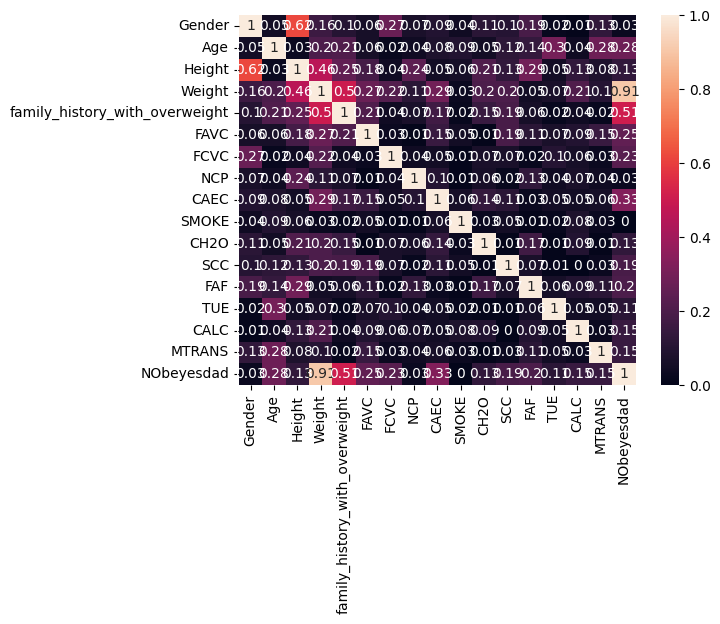

In [21]:
# Correlation Analysis

# float_combined_df = raw_X[["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]]
# float_combined_df = scaled_X[["Gender", "Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]]
float_combined_df = pd.concat([scaled_X, scaled_y], axis=1)
# find correlation between features and label using correlation matrix
corr_matrix = float_combined_df.corr().round(2).abs()

# display corr matrix as heatmap to visual better
sns.heatmap(data=corr_matrix, annot=True)



Best attributes based on raw correlation (min=0.19):
- Age
- Height
- Weight
- family_history_with_overweight
- FAVC
- FCVC
- CAEC
- SCC
- FAF

Height is also included. Despite low correlation, it can still be a distinquishing factor. If more attributes are needed, the next set to include are the following (min~0.1):
- Gender
- CH2O
- TUE
- CALC
- MTRANS

This is used to later make the best/good/all dataframes

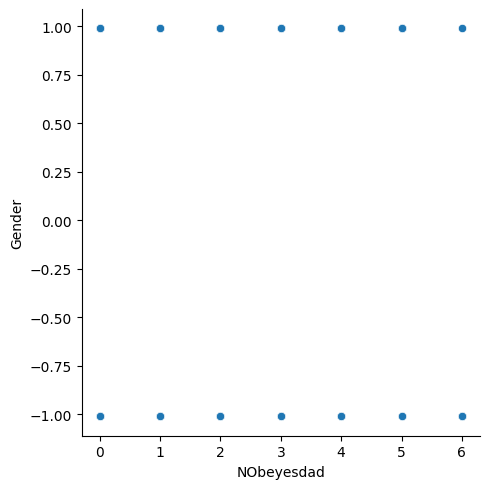

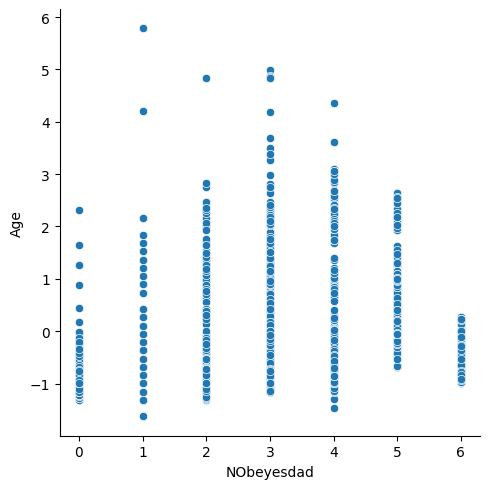

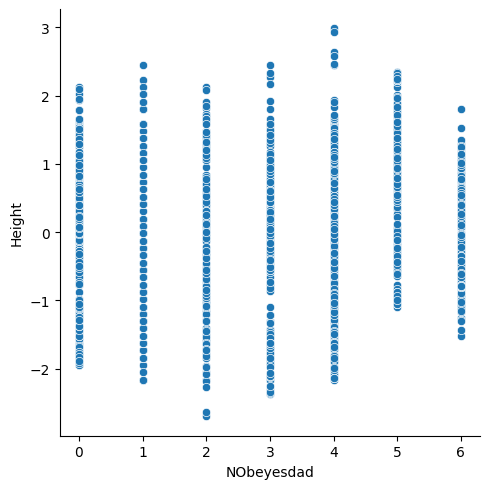

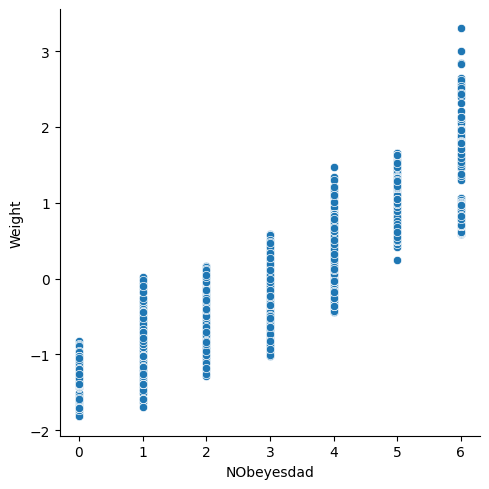

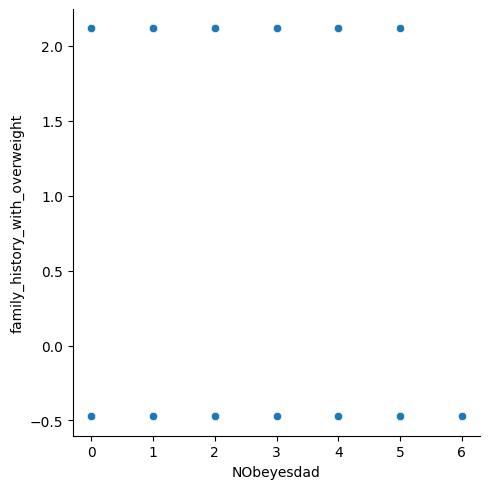

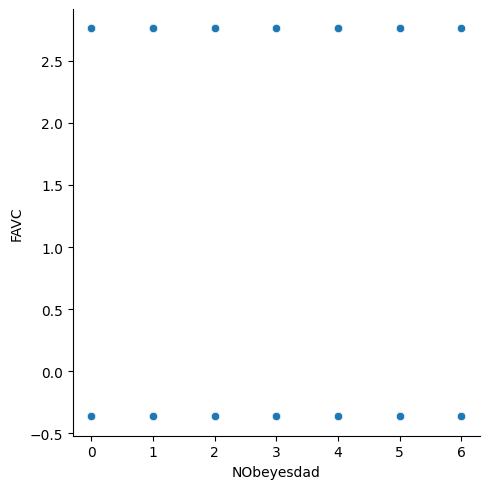

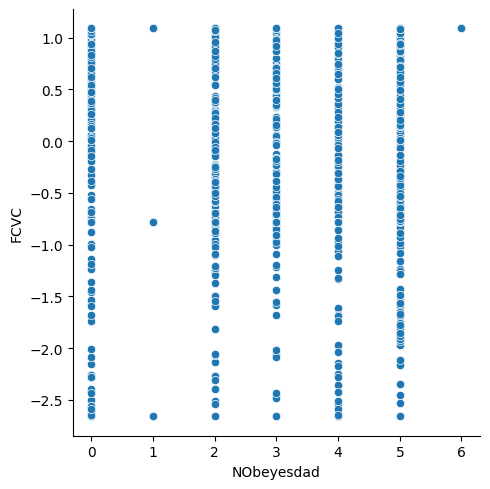

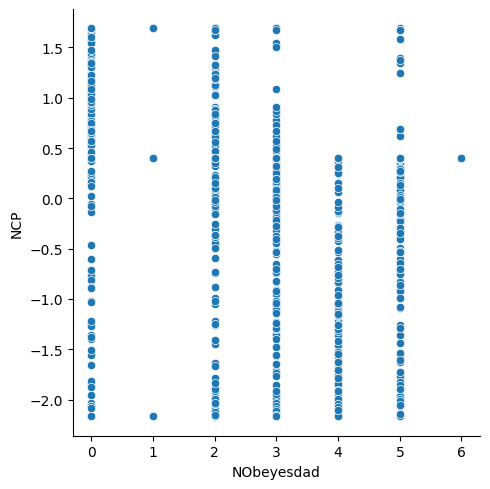

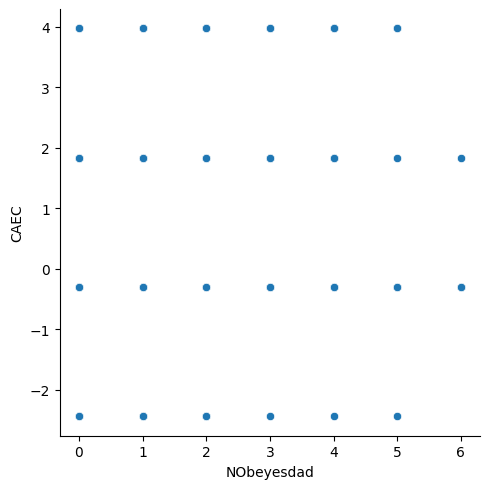

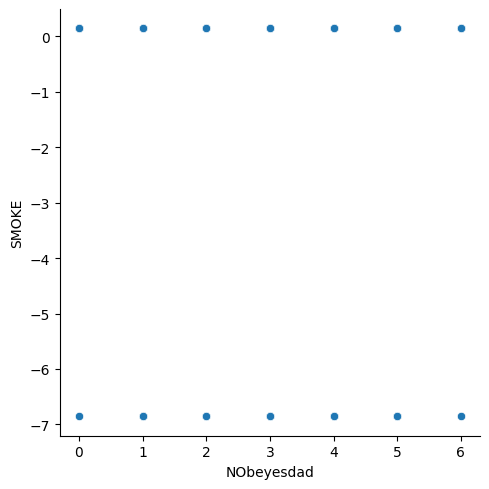

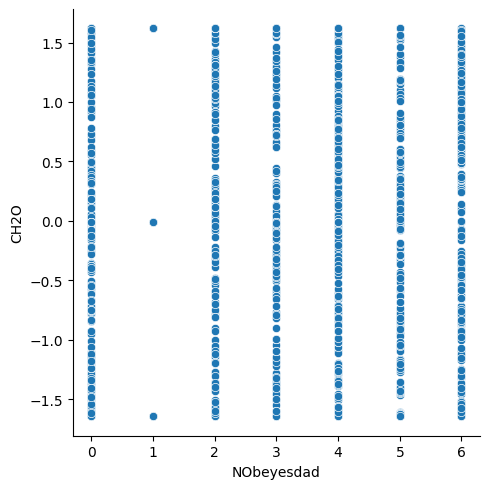

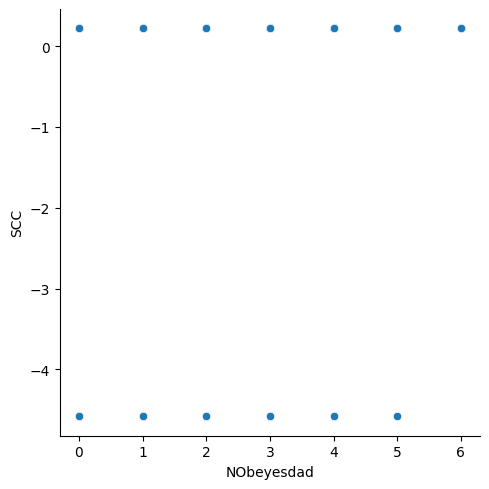

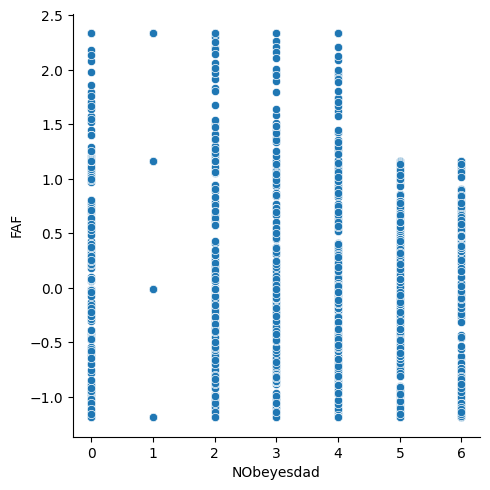

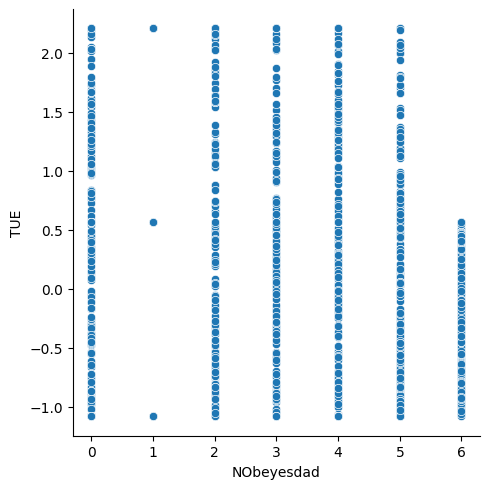

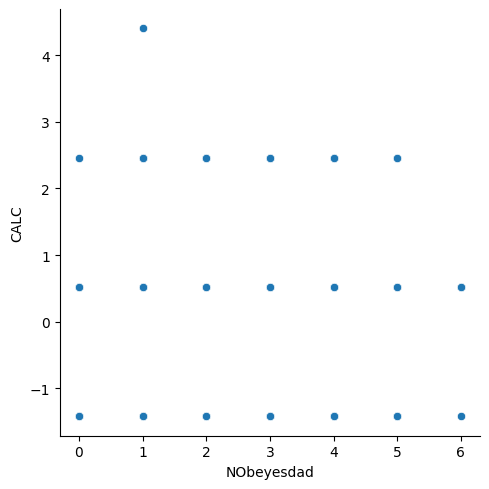

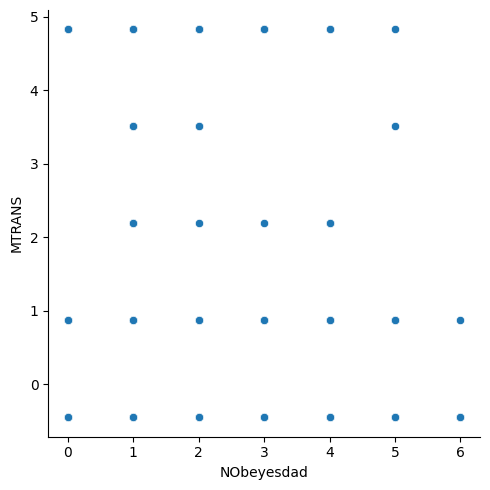

In [22]:
sns.relplot(data=float_combined_df, x="NObeyesdad", y="Gender")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="Age")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="Height")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="Weight")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="family_history_with_overweight")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="FAVC")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="FCVC")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="NCP")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="CAEC")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="SMOKE")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="CH2O")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="SCC")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="FAF")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="TUE")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="CALC")
sns.relplot(data=float_combined_df, x="NObeyesdad", y="MTRANS")


### Data Preprocessing - Dataframe feature variants
&nbsp;&nbsp;&nbsp;&nbsp;The following cell hosts different variations of scaled_X. To recap, the evolution of the dataset is as follows:
- raw_X - Raw Dataset
- clean_X - raw_X with conversions from object to float64, requiring ordering in some cases
- scaled_X - clean_X with standardization and normalization

scaled_X is then split into best_features, good_features and all_features by different sets of attributes. This allows us to switch training dataframes seamlessly later in the code

In [23]:
# This cell allows us to switch between different portions of the dataset

best_features = ["Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "CAEC", "SCC", "FAF"]
good_features = ["Gender", "Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "CAEC", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]
all_features = ["Gender", "Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]

best_X = scaled_X[best_features]
good_X = scaled_X[good_features]
all_X = scaled_X # Still included so that best_X, good_X and all_X can easily be swapped in for each other in subsequent cells.


In [24]:
# split data into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_X, scaled_y, test_size = 0.2, random_state=1234)